# Import essential packages

In [1]:
import tensorly as tl
from tensorly.decomposition import parafac as CP ## CP
from tensorly.decomposition import tucker  ## Tucker
from tensorly.decomposition import tensor_train as TT ## Tensor-trian
from tensorly import tucker_to_tensor
import tensorly.tenalg as talg

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
from tqdm import trange
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
from sklearn.metrics import accuracy_score
import argparse
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
# from dataloader import MnistBags
from mnist_bags_loader import MnistBags
from model import Attention, GatedAttention
from DataTransform import convert_data
from utils import *

## 1. Synthesis data

In [4]:
from skimage import io
from sklearn import preprocessing as pre
from skimage.transform import rescale, resize
data_path = r"./raw_data/tumor_backgrounds/"
backgrounds = []
for i in range(1500):
    try:
        ### ----------- homogeneous
        # cropped = io.imread("./raw_data/tumor.jpg", as_gray="True")[32:232,25:205]
        ####-------------heterogeneous
        tumor_img = io.imread(os.path.join(data_path,"no"+ str(i) +".jpg"), as_gray="True")[20:-20,20:-20]
        cropped = resize(tumor_img,(200,180))
        # backgrounds.append(normalize_negative_one(cropped))
        backgrounds.append((cropped))
        # backgrounds.append(pre.minmax_scale(cropped))
    except:
        pass

# p1,p2 = 10,10
# d1,d2 = 20,18  ## 20,18
scale = 1
p1,p2 = int(10/scale),int(10/scale)
d1,d2 = 20*scale,18*scale  ## 20,18
P = p1 * p2
D1,D2 = tumor_img.shape
print("img shape : ",tumor_img.shape)

img shape :  (211, 161)


In [8]:
shift_intensity = 50
signal_intensity = 0.7
n = len(backgrounds)
print("total sample size n : ", n)
r = 20
tumor_list,tumor_seg_list  = [],[]
data_path = r"D:\OneDrive\OneDrive - connect.hku.hk\Codes\IndividualizedRegionSelectionMIL\raw_data\Kaggle_brain_tumor\no_selected"

n = len(backgrounds)
num_tumors = int(n * 0.7)
Y = []
np.random.seed(5)
tumor_indices = np.random.choice(np.arange(n),num_tumors) #int(n/2)+20
for i in range(n):
    img = backgrounds[i]
    # img = backgrounds[0]
    if i in tumor_indices: 
        ell1,ell2 = shift_circle(img, 100,90,r,1,shift_inten = shift_intensity, signal_inten = signal_intensity)
        Y.append(1)
    else:
        ell1 = [img]
        ell2 = [np.zeros_like(img)]
        Y.append(0)
    tumor_list.extend(ell1)
    tumor_seg_list.extend(ell2)

total sample size n :  1058


### 1.1 Visualize tumor

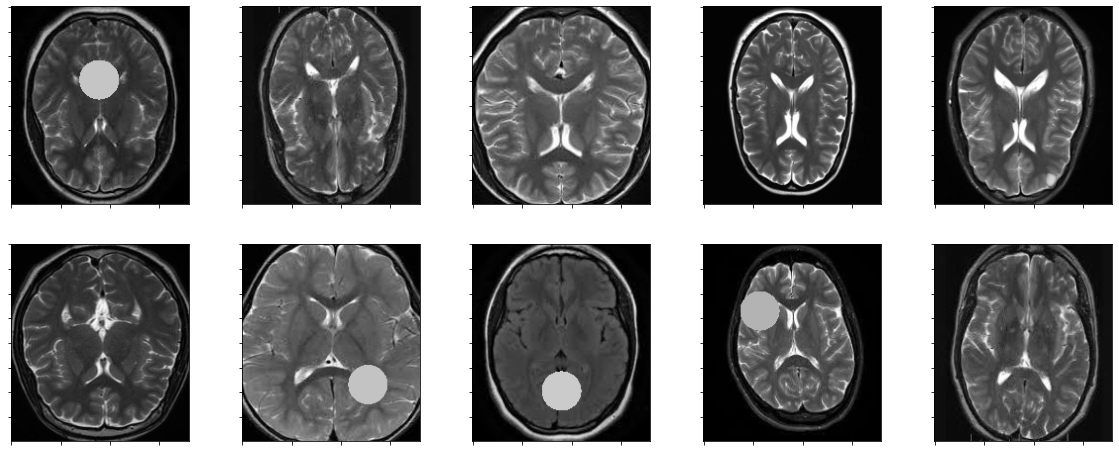

In [9]:
from functools import reduce
from matplotlib import ticker
from pathlib import Path
fig,ax = plt.subplots(figsize = (20,8))
kkk = [5,6,7,8,12,15,17,19,20,21]
for i in range(10):
    ax = plt.subplot(2,5,i+1)
    i = kkk[i]
    imshowobj = plt.imshow(tumor_list[i],"gray")
    # imshowobj.set_clim(0,1)
    # grid_size = (20,18) 
    # ax.xaxis.set_major_locator(ticker.IndexLocator(offset=0, base=20))
    # ax.yaxis.set_major_locator(ticker.IndexLocator(offset=0, base=18))
    # ax.grid(which='major', axis='both', linewidth=0.7, linestyle='-.', color='w')
    # ax.tick_params(bottom=False, top=False, left=False, right=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

save_dir = r"D:\OneDrive\OneDrive - connect.hku.hk\Codes\IndividualizedRegionSelectionMIL\res_data"
# plt.savefig(Path(save_dir,"tumor_illus_10.pdf"), dpi = 300, bbox_inches = "tight", pad_inches = 0)

In [12]:
from my_operator import *
from utils import *
X_train, Y_train, X_test, Y_test = [],[],[],[]
np.random.seed(539)
num_test = 153
_cut_num = 300
num_train = min(n - num_test,_cut_num)
print("training size: ", num_train)
print("total number size: ", n)
train_indices = np.random.choice(np.arange(n),size = num_train, replace = False) #int(n/2)+20
print("train_indices: ", len(train_indices))


# ins_label_test = []
# ins_label_train = []
# tmp2 = cut_T_pro(np.array(tumor_img),(p1,p2)).reshape(P,d1,d2)
test_count = 0
g_test = []
g_train = []
for i in range(n):
    ###tumor_list contains all images
    # tmp1 = cut_T_pro(tumor_list[i],(p1,p2)).reshape(P,d1,d2)
    tmp1 = Rearrange(tumor_list[i],p1,d1,p2,d2,p3=1,d3=1).reshape(P,d1,d2)
    # tmp2 = cut_T_pro(np.array(backgrounds[i]),(p1,p2)).reshape(P,d1,d2)
    ins_tmp = cut_T_pro(tumor_seg_list[i],(p1,p2)).reshape(P,d1,d2)
    ins_label = np.sum(ins_tmp,axis = (1,2))
    ins_label = np.where(ins_label == 0,ins_label,1)
    bag_label = Y[i]
    if i in train_indices:
        g_train.append(tumor_list[i])
        X_train.append(tmp1)
        Y_train.append((bag_label,ins_label))
    else:
        # if test_count < num_test:
        g_test.append(tumor_list[i])
        X_test.append(tmp1)
        # Y_test.append((bag_label, np.zeros(P)))
        Y_test.append((bag_label,ins_label))
        test_count += 1

X_test = X_test[:num_test]
Y_test = Y_test[:num_test]
g_test = g_test[:num_test]

bag_label_train = [i[0] for i in Y_train]
bag_label_test = [i[0] for i in Y_test]

training size:  300
total number size:  1058
train_indices:  300


## 2. Modeling

In [15]:
train_loader, test_loader = convert_data(X_train,Y_train,X_test,Y_test,batch_size= 1)
# ins_label

### 2.1 Configurations

In [24]:
from net import *
from modules.criterion import *
data_type = "matrix" # matrix / tensor,  default = matrix
model_type = "nn" # logistic / nn, default = nn
img_sz = [d1,d2]
model = MIL(img_sz,data_type,model_type)
### setting GPU
use_cuda = torch.cuda.is_available()
print("is cuda available: ",use_cuda)
if use_cuda:
    model = model.cuda()
learning_rate = 1 * 1e-3 ## 4
### define the optimization algorithm
optimizer = optim.AdamW(model.parameters(), lr= learning_rate)
## define criterion
criterion = MLE(p1 = p1, p2 = p2)
## the total number of iteration 
num_epochs = 50 ## 50
## weight decay
decay_weight = 1 # 0.98

lam_tv = 1 * 1e-3  ## 0.01 default
lam_ins= 0

is cuda available:  True


### 2.3 Training

In [25]:
from sklearn import metrics
# def train(epoch):
ins_label = torch.tensor([0])
for epoch in range(1,num_epochs+1):
    model.train()
    train_loss = 0.
    # train_acc = 0.
    Y_label = []
    Y_hat_label = []
    for batch_idx,(data,label) in enumerate(train_loader):
        data = torch.unsqueeze(data,2)
        bag_label = label[0] + 0.  ## convert true-false to 1-0
        ins_label = label[1]
        if use_cuda:
            data, bag_label = data.cuda(), bag_label.cuda()
        # data, bag_label = Variable(data), Variable(bag_label)
        optimizer.zero_grad()
        # calculate loss and metrics
        y_hat,H= model(data.float()) #data.float()
        y_hat_label = 1 - torch.prod(1/( 1 + torch.exp(y_hat)))
        # y_hat_label = torch.ge(y_hat_label,0.5) + 0
        loss = criterion(bag_label, ins_label,y_hat,lam_tv,lam_ins)
        train_loss += loss.item()
        Y_label.append(bag_label.squeeze().detach().cpu().numpy())
        Y_hat_label.append(y_hat_label.squeeze().detach().cpu().numpy())
        # backward pass
        loss.backward()
        # step
        optimizer.step()
    # calculate loss and error for epoch
    train_loss /= len(train_loader)
    # train_acc = accuracy_score(Y_label,Y_hat_label)        
    fpr, tpr, thresholds = metrics.roc_curve(Y_label, Y_hat_label)
    train_auc = metrics.auc(fpr, tpr)   
    # train_error /= len(train_loader)
    if epoch % 5 == 0:
    # print('Epoch: {}, Loss: {:.4f}, Train error: {:.4f}'.format(epoch, train_loss.cpu().numpy()[0], train_error))
        print('Epoch: {}, Loss: {:.8f}, Train auc: {:.6f}'.format(epoch, train_loss, train_auc))

Epoch: 5, Loss: 0.69396960, Train auc: 0.623227
Epoch: 10, Loss: 0.68769942, Train auc: 0.648437
Epoch: 15, Loss: 0.64909357, Train auc: 0.705393
Epoch: 20, Loss: 0.54886014, Train auc: 0.874661
Epoch: 25, Loss: 0.40971303, Train auc: 0.962163
Epoch: 30, Loss: 0.38073657, Train auc: 0.972433
Epoch: 35, Loss: 0.37050639, Train auc: 0.977013
Epoch: 40, Loss: 0.33923437, Train auc: 0.981281
Epoch: 45, Loss: 0.33942256, Train auc: 0.986661
Epoch: 50, Loss: 0.30875941, Train auc: 0.994220


In [26]:
model.parameters

<bound method Module.parameters of MIL(
  (feature_extractor_part1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature_extractor_part2): Sequential(
    (0): Linear(in_features=1000, out_features=1, bias=False)
  )
)>

### 2.4 Testing

In [36]:
model.eval()
Y_label = []
Y_hat_label = []
ty_hat_list = []
tdata_list = []
ins_label_list = []
bag_label_list = []
for batch_idx, (data, label) in enumerate(test_loader):
# for batch_idx, (data, label) in enumerate(train_loader):
    data = torch.unsqueeze(data,2)
    bag_label = label[0] + 0  ## convert true-false to 1-0
    ins_label = label[1].squeeze()
    if use_cuda:
        data, bag_label = data.cuda(), bag_label.cuda()
    y_hat,_ = model(data.float())
    y_hat_label = 1 - torch.prod(1/( 1 + torch.exp(y_hat)))
    ## one-hot, thresholding
    # y_hat_label = torch.ge(y_hat_label,0.5) + 0
    Y_label.append(bag_label.squeeze().detach().cpu().numpy())
    Y_hat_label.append(y_hat_label.squeeze().detach().cpu().numpy())
    # ty_hat = np.round((1/( 1 + torch.exp(-y_hat))).detach().cpu().numpy(),100)
    ty_hat = (1/( 1 + torch.exp(-y_hat))).detach().cpu().numpy()
    tdata = data.detach().cpu().numpy().squeeze().squeeze()
    ty_hat_list.append(ty_hat)
    tdata_list.append(tdata)
    ins_label_list.append(ins_label.numpy())
    bag_label_list.append(bag_label.cpu().numpy()[0])

In [28]:
ins_label_all = []
for i in ins_label_list:
    ins_label_all.extend(i)

ins_hat_all = []
for i in ty_hat_list:
    ins_hat_all.extend(i)

In [29]:
# len(ins_label_all)
# ty_hat
# type()
# len(ins_hat_all)
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
precision_IRD, recall_IRD,th = precision_recall_curve(ins_label_all, ins_hat_all)
auc_IRD = metrics.auc(recall_IRD, precision_IRD)
print("auprc of auc_IRD: ",auc_IRD)

auprc of auc_IRD:  0.6487776936938129


In [30]:
from utils import *
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_label, Y_hat_label)
print("test auc: ",np.round(metrics.auc(fpr, tpr),5))
Y_hat_label_ = [1 if x >=0.5 else 0 for x in Y_hat_label]
TPR,TNR,ACC = cls_measure(Y_label,Y_hat_label_)
print("the acc of testing: ",ACC)
print("the tpr of testing: ",np.round(TPR,5))
print("the tnr of testing: ",np.round(TNR,5))

test auc:  1.0
the acc of testing:  0.9869281045751634
the tpr of testing:  1.0
the tnr of testing:  0.97183


### 2.5 Plot

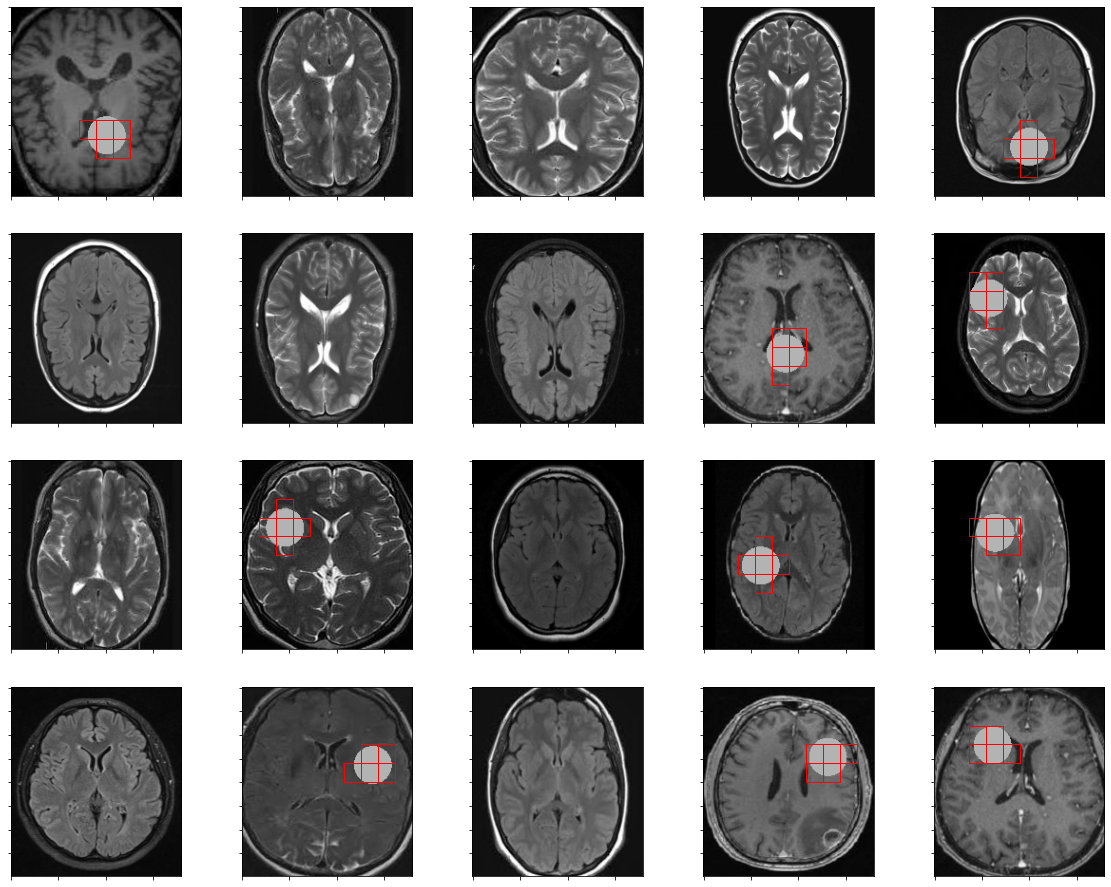

In [38]:
from functools import reduce
from matplotlib import ticker
from pathlib import Path
import matplotlib.patches as patches
fig,ax = plt.subplots(figsize = (20,16)) 
# kkk = [5,6,7,8,12,15,17,19,20,21]
# kkk = [0,1,3,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,26]
kkk = np.random.choice(np.arange(50),20)
for i in range(20):
    ax = plt.subplot(4,5,i+1)
    # i = kkk[i]
    ins_label = ins_label_list[i]
    bag_label = bag_label_list[i]
    # imshowobj = ax.imshow(tumor_list[i],"gray")
    # imshowobj = ax.imshow(g_test[i],"gray")
    tdata ,_ = R_inv(tdata_list[i].reshape(p1*p2,d1*d2),p1,d1,p2,d2,p3=1,d3=1)
    imshowobj = ax.imshow(tdata,"gray")
    imshowobj.set_clim(0,1)
    k_y_hat = ty_hat_list[i].squeeze()
    top_5_idx = k_y_hat.argsort()[-1:-6:-1]
    # top_5_idx = ins_label.argsort()[-1:-6:-1]
    # row = np.where(ins_label != 0)[0]//10
    # col = np.where(ins_label != 0)[0]%10
    row = top_5_idx//10
    col = top_5_idx % 10
    if bag_label:
        for j in range(len(row)):
            s1,s2 = row[j]*d1, col[j]*d2 
            rect = patches.Rectangle((s2, s1), d2, d1, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

save_dir = r"D:\OneDrive\OneDrive - connect.hku.hk\Codes\IndividualizedRegionSelectionMIL\res_data"
# plt.savefig(Path(save_dir,"tumor_illus_res20_proposal.pdf"), dpi = 300, bbox_inches = "tight", pad_inches = 0)